In [3]:
# # 현재 작업 디렉토리
# !pwd

/content


In [4]:
# # 구글 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# # 원하는 위치로 경로 바꾸기
# # 본인이 만든 폴더 위치를 사용
# %cd /content/drive/MyDrive/mulcam_bigdata/

/content/drive/MyDrive/mulcam_bigdata


In [1]:
!pip install konlpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
import re
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings
import ast

from matplotlib import font_manager, rc
from scipy.stats import f_oneway
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import tee
from scipy.stats import chi2_contingency

from wordcloud import WordCloud
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [3]:
df_reviews = pd.read_csv('hugging_face_모델.csv')
df_reviews.head()

,Unnamed: 0,reviews,pred,감정,nouns
0,0,['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...,1,긍정,"['배송', '생각', '도착', '손목', '스트랩', '쌍', '레드', '디자..."
1,1,'배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ',1,긍정,"['배송', '색상', '디자인', '마감', '처리', '가성', '비', '강력..."
2,2,'정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩...,1,긍정,"['정말', '이상인', '듯', '나', '의', '리프', '팅', '스트랩',..."
3,3,'3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미...,1,긍정,"['개중', '개', '포장', '상태', '상품', '아무', '문제', '미끄럼..."
4,4,'아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.',0,부정,"['배송', '배송', '지연', '배송', '무료', '쿠폰']"


In [4]:
# 데이터의 첫 몇 행을 출력
print(df_reviews.head())

# 데이터의 정보 출력 (열 이름, 데이터 타입 등)
print(df_reviews.info())

# 데이터의 통계 요약 출력
print(df_reviews.describe())


   Unnamed: 0                                            reviews  pred  감정  \
0           0  ['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...     1  긍정   
1           1   '배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ'     1  긍정   
2           2   '정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩...     1  긍정   
3           3   '3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미...     1  긍정   
4           4               '아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.'     0  부정   

                                               nouns  
0  ['배송', '생각', '도착', '손목', '스트랩', '쌍', '레드', '디자...  
1  ['배송', '색상', '디자인', '마감', '처리', '가성', '비', '강력...  
2  ['정말', '이상인', '듯', '나', '의', '리프', '팅', '스트랩',...  
3  ['개중', '개', '포장', '상태', '상품', '아무', '문제', '미끄럼...  
4               ['배송', '배송', '지연', '배송', '무료', '쿠폰']  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15351 entries, 0 to 15350
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed:

In [5]:
df_reviews.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df_reviews.head(3)

,reviews,pred,감정,nouns
0,['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...,1,긍정,"['배송', '생각', '도착', '손목', '스트랩', '쌍', '레드', '디자..."
1,'배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ',1,긍정,"['배송', '색상', '디자인', '마감', '처리', '가성', '비', '강력..."
2,'정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩...,1,긍정,"['정말', '이상인', '듯', '나', '의', '리프', '팅', '스트랩',..."


In [7]:
import collections

# 한 글자 단어 제거 함수 (단, '굿' 제외)
def remove_single_character_words(word_list):
    return [word for word in word_list if len(word) > 1 or word == '굿']

# 단어 치환 함수
def replace_words(word_list):
    replacements = {
        '물건': '제품',
        '상품': '제품',
        '재품': '제품',
        '성품': '제품',
        '굿': '좋음',
        '최고': '좋음',
        '만족': '좋음'
    }
    return [replacements.get(word, word) for word in word_list]

# '감정'이 '긍정'인 행들 필터링 및 전처리 (긍정 리뷰들만)
for index, row in df_reviews.iterrows():
    if row['감정'] == '긍정':
        nouns_list = ast.literal_eval(row['nouns'])  # 문자열을 리스트로 변환
        nouns_list = remove_single_character_words(nouns_list)  # 한 글자 단어 제거
        nouns_list = replace_words(nouns_list)  # 단어 치환
        df_reviews.at[index, 'nouns'] = str(nouns_list)  # 열 업데이트

# 결과 출력
print(df_reviews.head())

                                             reviews  pred  감정  \
0  ['배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔...     1  긍정   
1   '배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ'     1  긍정   
2   '정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩...     1  긍정   
3   '3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미...     1  긍정   
4               '아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.'     0  부정   

                                               nouns  
0  ['배송', '생각', '도착', '손목', '스트랩', '레드', '디자인', '...  
1  ['배송', '색상', '디자인', '마감', '처리', '가성', '강력', '추천']  
2  ['정말', '이상인', '리프', '스트랩', '비교', '기능', '전혀', '...  
3  ['개중', '포장', '상태', '제품', '아무', '문제', '미끄럼', '방...  
4               ['배송', '배송', '지연', '배송', '무료', '쿠폰']  


In [8]:
# 'nouns' 열을 그대로 사용
tokenized_reviews = df_reviews['nouns'].tolist()

# 토큰 리스트가 올바른 형태인지 샘플 출력
for i in range(5):
    print(tokenized_reviews[i])

['배송', '생각', '도착', '손목', '스트랩', '레드', '디자인', '마감', '처리', '스트랩', '로고', '처리', '고급', '스트랩', '미끄렁방', '처리', '구매', '정말', '강력', '추천']
['배송', '색상', '디자인', '마감', '처리', '가성', '강력', '추천']
['정말', '이상인', '리프', '스트랩', '비교', '기능', '전혀', '문제', '착용', '사용', '전이', '장시간', '사용', '실리콘', '바느질']
['개중', '포장', '상태', '제품', '아무', '문제', '미끄럼', '방지', '처리', '가성']
['배송', '배송', '지연', '배송', '무료', '쿠폰']


In [9]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
# 퍼플렉서티와 코히런스 계산을 위한 함수
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=100, passes=10, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [10]:
pip install koreanize_matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import koreanize_matplotlib

# 긍정 리뷰에 대해 최적의 주제 수 찾기
limit = 10  # 최대로 테스트할 주제 수
start = 2
step = 2
positive_model_list, positive_coherence_values = compute_coherence_values(dictionary=positive_dictionary,
                                                                          corpus=positive_corpus,
                                                                          texts=positive_tokenized,
                                                                          start=start, limit=limit,
                                                                          step=step)
# Coherence 점수 그래프 그리기 (긍정 리뷰)
x = range(start, limit, step)
plt.plot(x, positive_coherence_values)
plt.xlabel("토픽 개수")
plt.ylabel("Coherence 점수")
plt.title("긍정 리뷰에 대한 최적의 토픽 개수")
plt.show()

# 부정 리뷰에 대해 최적의 주제 수 찾기
negative_model_list, negative_coherence_values = compute_coherence_values(dictionary=negative_dictionary,
                                                                          corpus=negative_corpus,
                                                                          texts=negative_tokenized,
                                                                          start=start,
                                                                          limit=limit,
                                                                          step=step)
# Coherence 점수 그래프 그리기 (부정 리뷰)
x = range(start, limit, step)
plt.plot(x, negative_coherence_values)
plt.xlabel("토픽 개수")
plt.ylabel("Coherence 점수")
plt.title("부정 리뷰에 대한 최적의 토픽 개수")

NameError: name 'positive_dictionary' is not defined

In [12]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim import corpora
import ast


# 데이터 샘플링
df_sampled = df_reviews.sample(n=3000, random_state=42)

# 'nouns' 열을 문자열에서 리스트로 변환
df_sampled['nouns'] = df_sampled['nouns'].apply(ast.literal_eval)

# 예외 단어 리스트 설정
exception_words = {'굿'}

# 한글자 단어 제거 함수 정의
def remove_single_characters(tokens):
    return [token for token in tokens if len(token) > 1 or token in exception_words]

# 빈 리스트 제거 및 한글자 단어 제거
tokenized_reviews = [remove_single_characters(tokens) for tokens in df_sampled['nouns'].tolist() if tokens]

# 긍정과 부정 리뷰로 분리
positive_reviews = df_sampled[df_sampled['감정'] == '긍정']
negative_reviews = df_sampled[df_sampled['감정'] == '부정']

# 긍정 리뷰 처리
positive_tokenized = [remove_single_characters(tokens) for tokens in positive_reviews['nouns'].tolist() if tokens]
positive_dictionary = corpora.Dictionary(positive_tokenized)
positive_corpus = [positive_dictionary.doc2bow(tokens) for tokens in positive_tokenized]

# 부정 리뷰 처리
negative_tokenized = [remove_single_characters(tokens) for tokens in negative_reviews['nouns'].tolist() if tokens]
negative_dictionary = corpora.Dictionary(negative_tokenized)
negative_corpus = [negative_dictionary.doc2bow(tokens) for tokens in negative_tokenized]

# LDA 모델 구축
k = 6
positive_lda_model = LdaMulticore(corpus=positive_corpus, num_topics=k, id2word=positive_dictionary, iterations=100, passes=10, workers=4, random_state=42)


# 긍정 토픽 출력
print("긍정 리뷰 토픽:")
for idx, topic in positive_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

긍정 리뷰 토픽:
Topic: 0 
Words: 0.033*"작동" + 0.017*"게임" + 0.016*"정말" + 0.012*"도착" + 0.010*"가격" + 0.010*"구매" + 0.010*"인식" + 0.009*"사용" + 0.009*"배송" + 0.009*"제품"

Topic: 1 
Words: 0.149*"배송" + 0.054*"제품" + 0.051*"아주" + 0.021*"사용" + 0.020*"가격" + 0.015*"구매" + 0.011*"도착" + 0.010*"포장" + 0.009*"조금" + 0.008*"생각"

Topic: 2 
Words: 0.089*"가격" + 0.063*"가성" + 0.042*"대비" + 0.029*"매우" + 0.022*"구매" + 0.022*"품질" + 0.019*"사용" + 0.017*"구입" + 0.014*"제품" + 0.012*"마음"

Topic: 3 
Words: 0.061*"생각" + 0.045*"충전" + 0.015*"가격" + 0.015*"제품" + 0.014*"음질" + 0.014*"사용" + 0.012*"크기" + 0.010*"작동" + 0.009*"구매" + 0.008*"다만"

Topic: 4 
Words: 0.088*"좋음" + 0.064*"제품" + 0.039*"가성" + 0.023*"추천" + 0.012*"구매" + 0.011*"성능" + 0.010*"가격" + 0.010*"소리" + 0.010*"사용" + 0.008*"아이"

Topic: 5 
Words: 0.058*"사용" + 0.019*"아주" + 0.018*"제품" + 0.013*"도착" + 0.012*"가성" + 0.012*"사이즈" + 0.012*"충전" + 0.011*"게임" + 0.010*"문제" + 0.009*"그냥"



In [13]:
k = 6
negative_lda_model = LdaMulticore(corpus=negative_corpus, num_topics=k, id2word=negative_dictionary, iterations=100, passes=10, workers=4, random_state=42)

# 부정 토픽 출력
print("부정 리뷰 토픽:")
for idx, topic in negative_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

부정 리뷰 토픽:
Topic: 0 
Words: 0.039*"가격" + 0.020*"사용" + 0.015*"기능" + 0.013*"구매" + 0.012*"정도" + 0.011*"그냥" + 0.010*"인식" + 0.009*"사진" + 0.008*"쓰기" + 0.007*"부분"

Topic: 1 
Words: 0.071*"사용" + 0.069*"제품" + 0.062*"가성" + 0.016*"배송" + 0.009*"게임" + 0.008*"환불" + 0.007*"성능" + 0.006*"가격" + 0.006*"쓰레기" + 0.006*"조금"

Topic: 2 
Words: 0.043*"배송" + 0.024*"한글" + 0.017*"그냥" + 0.014*"사용" + 0.014*"한국어" + 0.014*"구매" + 0.013*"지원" + 0.013*"상품" + 0.012*"가격" + 0.010*"도착"

Topic: 3 
Words: 0.017*"사용" + 0.013*"연결" + 0.012*"작동" + 0.011*"화면" + 0.010*"하나" + 0.008*"배송" + 0.008*"시간" + 0.007*"도착" + 0.006*"밝기" + 0.006*"불량품"

Topic: 4 
Words: 0.025*"배송" + 0.025*"충전" + 0.021*"환불" + 0.016*"제품" + 0.014*"생각" + 0.014*"주문" + 0.012*"매우" + 0.011*"고속" + 0.011*"가격" + 0.010*"설치"

Topic: 5 
Words: 0.018*"구입" + 0.018*"제품" + 0.016*"음질" + 0.015*"별로" + 0.015*"사지" + 0.011*"색상" + 0.011*"메모리" + 0.010*"사용" + 0.008*"충전" + 0.008*"한국어"



In [14]:
!pip install pyLDAvis

In [15]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt

# pyLDAvis 시각화 생성
positive_vis = gensimvis.prepare(positive_lda_model, positive_corpus, positive_dictionary)
negative_vis = gensimvis.prepare(negative_lda_model, negative_corpus, negative_dictionary)

# 코랩에서 시각화 표시
pyLDAvis.enable_notebook()

# # 긍정 리뷰 시각화
positive_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.093517 -0.140273       1        1  19.987089
2      0.175090 -0.007172       2        1  18.066545
4      0.063920 -0.049828       3        1  16.915309
5     -0.068699  0.023551       4        1  16.310189
0     -0.031822  0.057282       5        1  15.233220
3     -0.044971  0.116441       6        1  13.487648, topic_info=   Term        Freq       Total Category  logprob  loglift
4    배송  306.000000  306.000000  Default  30.0000  30.0000
87   좋음  169.000000  169.000000  Default  29.0000  29.0000
2    가격  243.000000  243.000000  Default  28.0000  28.0000
56   가성  200.000000  200.000000  Default  27.0000  27.0000
5    아주  133.000000  133.000000  Default  26.0000  26.0000
..  ...         ...         ...      ...      ...      ...
58   도착    9.653414   72.170751   Topic6  -4.8802  -0.0083
55   추천    9.278115   67.504970   Topic6  -4.9199   0.0189
12   구매   11.153483  121.407882   Topic6  -4.7358  -0.3840
51   게임    8.315100   68.797323   Topic6  -5.0294  -0.1097
29   이상    6.758415   31.902042   Topic6  -5.2367   0.4515

[419 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.155918   가격
2         2  0.619571   가격
2         3  0.065650   가격
2         4  0.016412   가격
2         5  0.061547   가격
...     ...       ...  ...
60        4  0.422389   후기
721       6  0.736142   흡수
1162      4  0.556534   흰색
1162      5  0.111307   흰색
1162      6  0.333921   흰색

[727 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 6, 1, 4])

In [16]:
# 부정 리뷰 시각화
negative_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.011469  0.134014       1        1  23.139568
1      0.154836  0.017690       2        1  22.231582
5      0.029934 -0.050384       3        1  15.276559
0     -0.087152  0.057871       4        1  13.595749
4      0.006513 -0.094795       5        1  13.352174
3     -0.092662 -0.064396       6        1  12.404368, topic_info=    Term       Freq      Total Category  logprob  loglift
100   가성  57.000000  57.000000  Default  30.0000  30.0000
13    제품  76.000000  76.000000  Default  29.0000  29.0000
14    배송  63.000000  63.000000  Default  28.0000  28.0000
20    사용  92.000000  92.000000  Default  27.0000  27.0000
166   가격  41.000000  41.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
151   구매   1.487598  29.942403   Topic6  -5.6890  -0.9150
99    환불   1.486929  21.021486   Topic6  -5.6895  -0.5617
121   유리   1.486884   4.336546   Topic6  -5.6895   1.0167
62    일반   1.486753   4.262279   Topic6  -5.6896   1.0339
102   만하   1.486342   3.588386   Topic6  -5.6899   1.2057

[375 rows x 6 columns], token_table=      Topic      Freq Term
term                      
166       1  0.239823   가격
166       2  0.119912   가격
166       3  0.071947   가격
166       4  0.455664   가격
166       5  0.119912   가격
...     ...       ...  ...
991       3  0.154246   후기
991       5  0.154246   후기
991       6  0.308492   후기
360       5  0.571470  휴대폰
360       6  0.285735  휴대폰

[595 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 1, 5, 4])

In [17]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# pyLDAvis 시각화 결과를 HTML 파일로 저장
pyLDAvis.save_html(positive_vis, '/content/lda_positive.html')
pyLDAvis.save_html(negative_vis, '/content/lda_negative.html')

FileNotFoundError: [Errno 2] No such file or directory: '/content/lda_positive.html'

In [32]:
# 긍정 리뷰 토픽 중요한 단어 및 명명 및 리뷰 예시 선택
important_positive_topics = {
    "Topic": [1, 2, 3],
    "Word1": ["배송", "가격", "좋음"],
    "Weight1": [0.149, 0.089, 0.088],
    "Word2": ["제품", "가성", "제품"],
    "Weight2": [0.054, 0.063, 0.064],
    "Word3": ["아주", "대비", "추천"],
    "Weight3": [0.051, 0.042, 0.023],
    "명명": ["가격 및 배송 만족", "가성비 좋음", "제품 좋음"],
    "리뷰 예시": [
        "배송이 아주 빠르고 제품도 만족스럽습니다.",
        "가격 대비 가성비가 좋아서 구매하게 되었습니다.",
        "제품 품질이 아주 좋고 사용하기 편리합니다."
    ]
}

# 부정 리뷰 토픽 중요한 단어 및 명명 및 리뷰 예시 선택
important_negative_topics = {
    "Topic": [1, 2, 3],
    "Word1": ["사용", "배송", "가격"],
    "Weight1": [0.071, 0.043, 0.039],
    "Word2": ["제품", "가성", "사용"],
    "Weight2": [0.069, 0.024, 0.020],
    "Word3": ["가성", "그냥", "환불"],
    "Weight3": [0.062, 0.017, 0.008],
    "명명": ["사용 불편", "배송 지연", "가격 부담"],
    "리뷰 예시": [
        "제품 사용이 불편합니다.",
        "배송이 예상보다 지연되어 불편했습니다.",
        "가격이 너무 부담스러워서 환불하려고 합니다."
    ]
}

# 데이터 프레임으로 변환
important_positive_df = pd.DataFrame(important_positive_topics)
important_negative_df = pd.DataFrame(important_negative_topics)

# 결과 출력
print("긍정 리뷰 토픽 중요한 단어:")
print(important_positive_df)
print("\n부정 리뷰 토픽 중요한 단어:")
print(important_negative_df)



긍정 리뷰 토픽 중요한 단어:
   Topic Word1  Weight1 Word2  Weight2 Word3  Weight3          명명  \
0      1    배송    0.149    제품    0.054    아주    0.051  가격 및 배송 만족   
1      2    가격    0.089    가성    0.063    대비    0.042      가성비 좋음   
2      3    좋음    0.088    제품    0.064    추천    0.023       제품 좋음   

                        리뷰 예시  
0     배송이 아주 빠르고 제품도 만족스럽습니다.  
1  가격 대비 가성비가 좋아서 구매하게 되었습니다.  
2    제품 품질이 아주 좋고 사용하기 편리합니다.  

부정 리뷰 토픽 중요한 단어:
   Topic Word1  Weight1 Word2  Weight2 Word3  Weight3     명명  \
0      1    사용    0.071    제품    0.069    가성    0.062  사용 불편   
1      2    배송    0.043    가성    0.024    그냥    0.017  배송 지연   
2      3    가격    0.039    사용    0.020    환불    0.008  가격 부담   

                      리뷰 예시  
0             제품 사용이 불편합니다.  
1     배송이 예상보다 지연되어 불편했습니다.  
2  가격이 너무 부담스러워서 환불하려고 합니다.  


In [34]:
important_positive_df

,Topic,Word1,Weight1,Word2,Weight2,Word3,Weight3,명명,리뷰 예시
0,1,배송,0.149,제품,0.054,아주,0.051,가격 및 배송 만족,배송이 아주 빠르고 제품도 만족스럽습니다.
1,2,가격,0.089,가성,0.063,대비,0.042,가성비 좋음,가격 대비 가성비가 좋아서 구매하게 되었습니다.
2,3,좋음,0.088,제품,0.064,추천,0.023,제품 좋음,제품 품질이 아주 좋고 사용하기 편리합니다.


In [33]:
important_positive_df.to_csv('important_positive_df.csv',encoding='utf-8-sig')

In [18]:
important_negative_df

NameError: name 'important_negative_df' is not defined

In [19]:
important_negative_df.to_csv('important_negative_df.csv',encoding='utf-8-sig')

NameError: name 'important_negative_df' is not defined

In [20]:
from gensim.models import CoherenceModel
# 엘보 방법을 사용한 최적 클러스터 수 찾기
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=100, passes=10, workers=4, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# 긍정 리뷰에 대한 최적 클러스터 수 찾기
start = 2
limit = 15
step = 1
positive_model_list, positive_coherence_values = compute_coherence_values(positive_dictionary, positive_corpus, positive_tokenized, limit, start, step)

# 부정 리뷰에 대한 최적 클러스터 수 찾기
negative_model_list, negative_coherence_values = compute_coherence_values(negative_dictionary, negative_corpus, negative_tokenized, limit, start, step)

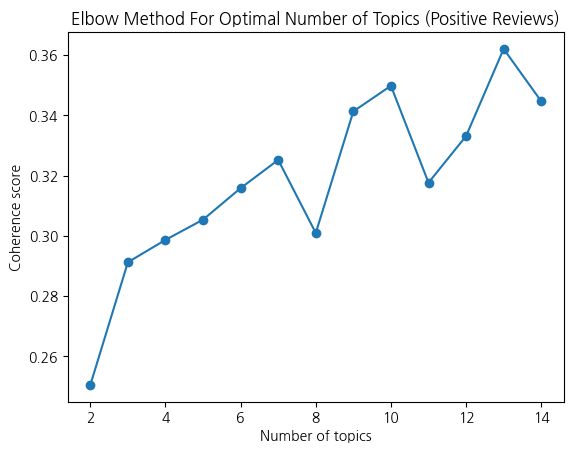

In [21]:
# 엘보 플롯 생성 (긍정 리뷰)
x = range(start, limit, step)
plt.plot(x, positive_coherence_values, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Elbow Method For Optimal Number of Topics (Positive Reviews)")
plt.show()

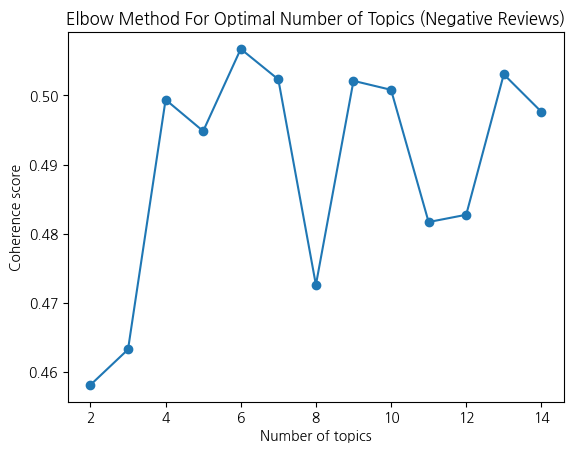

In [22]:
# 엘보 플롯 생성 (부정 리뷰)
plt.plot(x, negative_coherence_values, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Elbow Method For Optimal Number of Topics (Negative Reviews)")
plt.show()

In [23]:
# 긍정 리뷰 주제 분포 추출
positive_topic_distributions = positive_lda_model[positive_corpus]
positive_topic_vectors = [dict(doc) for doc in positive_topic_distributions]
positive_topic_vectors = pd.DataFrame(positive_topic_vectors).fillna(0).to_numpy()

# 부정 리뷰 주제 분포 추출
negative_topic_distributions = negative_lda_model[negative_corpus]
negative_topic_vectors = [dict(doc) for doc in negative_topic_distributions]
negative_topic_vectors = pd.DataFrame(negative_topic_vectors).fillna(0).to_numpy()


In [24]:
# 긍정 리뷰 군집 할당
positive_cluster_labels = np.argmax(positive_topic_vectors, axis=1)

# 부정 리뷰 군집 할당
negative_cluster_labels = np.argmax(negative_topic_vectors, axis=1)

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score

# 실루엣 분석 (긍정 리뷰)
positive_silhouette_avg = silhouette_score(positive_topic_vectors, positive_cluster_labels)
positive_sample_silhouette_values = silhouette_samples(positive_topic_vectors, positive_cluster_labels)

# 실루엣 분석 (부정 리뷰)
negative_silhouette_avg = silhouette_score(negative_topic_vectors, negative_cluster_labels)
negative_sample_silhouette_values = silhouette_samples(negative_topic_vectors, negative_cluster_labels)

In [48]:
# 최적의 K 찾기

# 실루엣 점수

from matplotlib import cm

def silhouetteviz(n_cluster, x_features):
  kmeans = KMeans(n_clusters=n_cluster, random_state=42)
  y_labels = kmeans.fit_predict(x_features)

  silhouette_values = silhouette_samples(x_features, y_labels, metric='euclidean')

  # 초기화
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []

  for c in range(n_cluster):
    c_silhouette = silhouette_values[y_labels == c]
    c_silhouette.sort()

    y_ax_upper += len(c_silhouette)

    color = cm.jet(float(c) / n_cluster)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette,
            height = 1.0, edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette)

  silhouette_avg = np.mean(silhouette_values)
  print(f'클러스터 {n_cluster}개일때 실루엣 계수 평균 : {silhouette_avg}')
  plt.axvline(silhouette_avg, color='red', linestyle='--')
  plt.title('Number of Cluster : '+str(n_cluster)+'\n'\
            +'Silhouette Score : '+str(round(silhouette_avg,3)))

  plt.yticks(yticks, list(range(n_cluster)))
  plt.xlabel([0,0.2,0.4,0.6,0.8,1.0])
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette coefficient values')
  plt.tight_layout()
  plt.show()
  


클러스터 2개일때 실루엣 계수 평균 : 0.2543657241623318


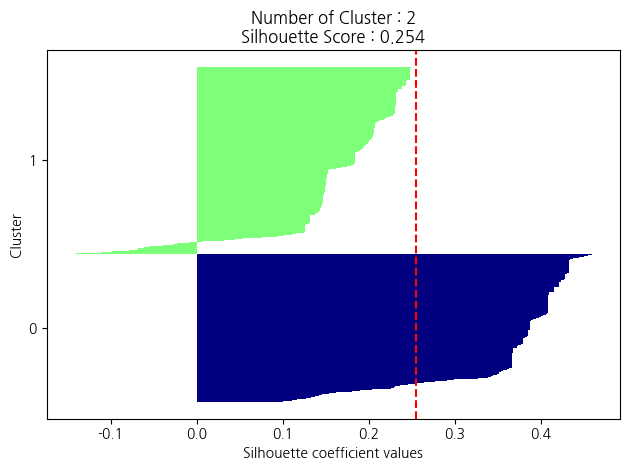

클러스터 3개일때 실루엣 계수 평균 : 0.3385902071119953


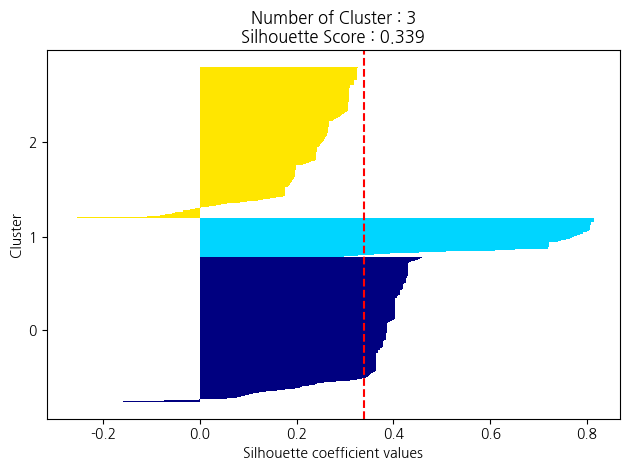

클러스터 4개일때 실루엣 계수 평균 : 0.4696643354498507


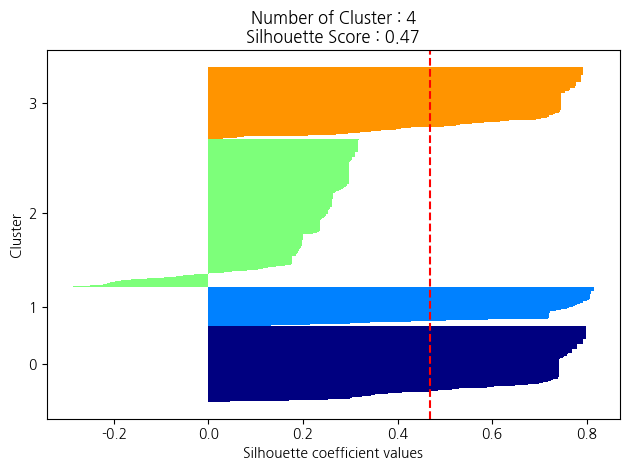

클러스터 5개일때 실루엣 계수 평균 : 0.576240453366759


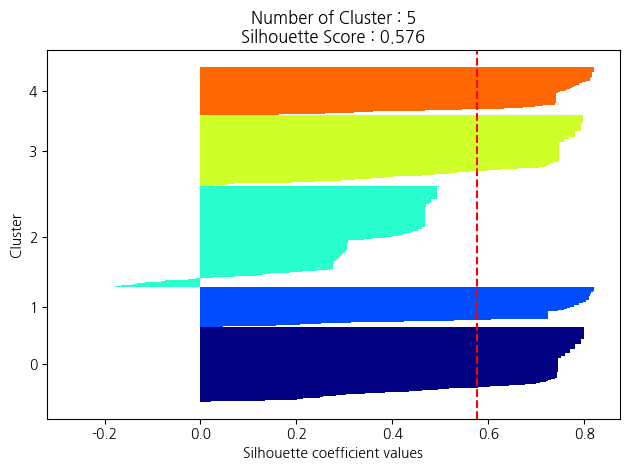

클러스터 6개일때 실루엣 계수 평균 : 0.6756405497207794


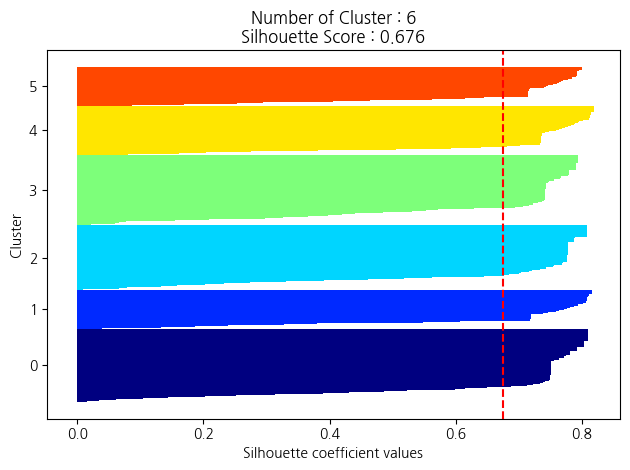

클러스터 7개일때 실루엣 계수 평균 : 0.617354593649756


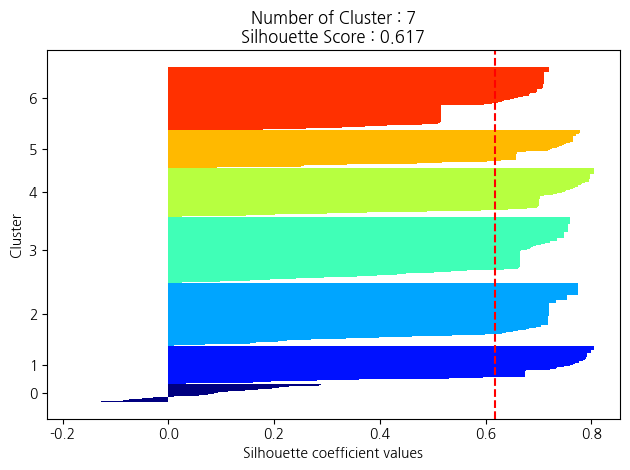

클러스터 8개일때 실루엣 계수 평균 : 0.5848619343600368


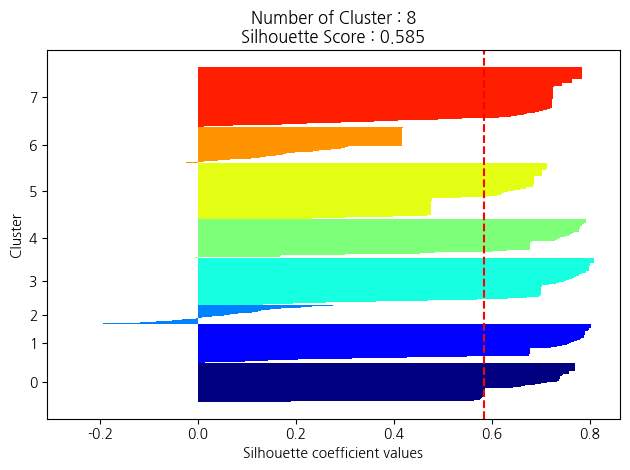

클러스터 9개일때 실루엣 계수 평균 : 0.5445323591165955


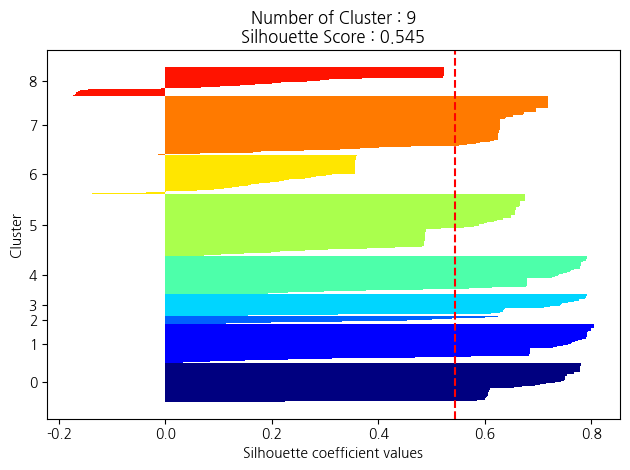

클러스터 10개일때 실루엣 계수 평균 : 0.5062682435623092


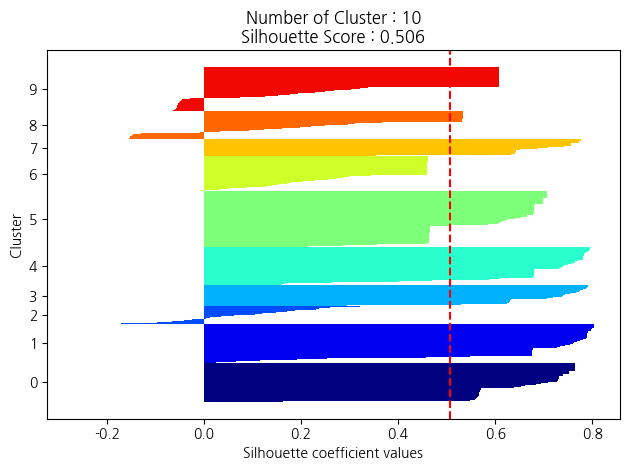

클러스터 11개일때 실루엣 계수 평균 : 0.5044901879878952


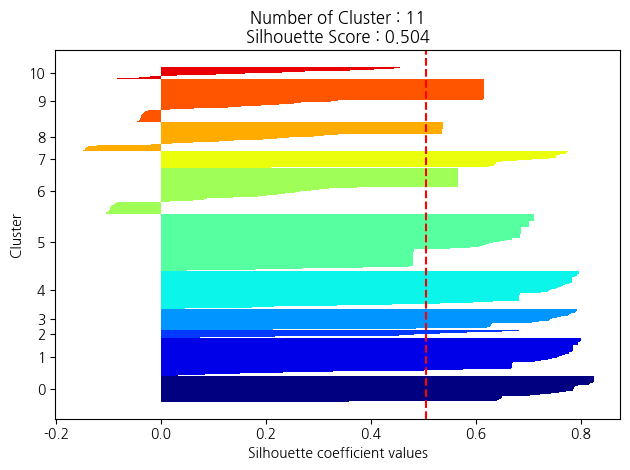

클러스터 12개일때 실루엣 계수 평균 : 0.4867244318944927


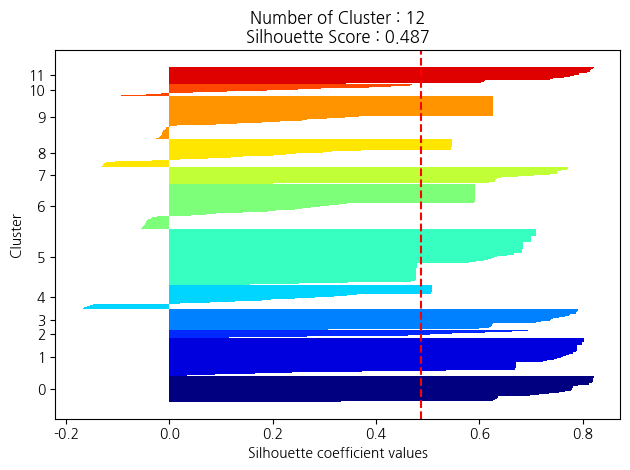

클러스터 13개일때 실루엣 계수 평균 : 0.48451231883665524


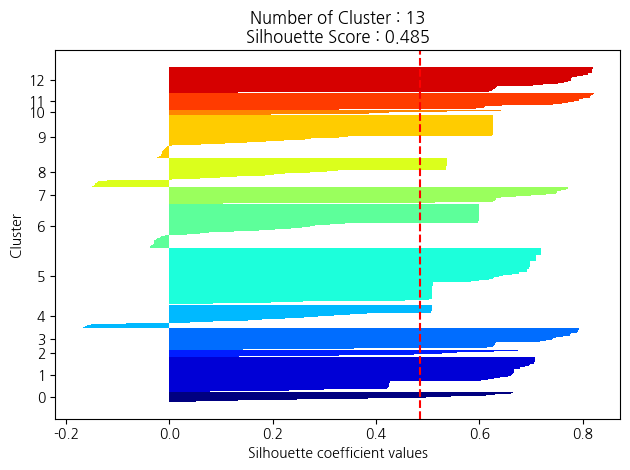

클러스터 14개일때 실루엣 계수 평균 : 0.4944361774482957


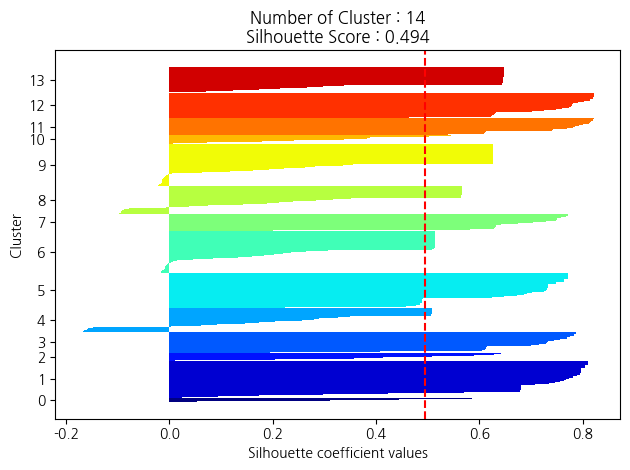

클러스터 15개일때 실루엣 계수 평균 : 0.4829231245110406


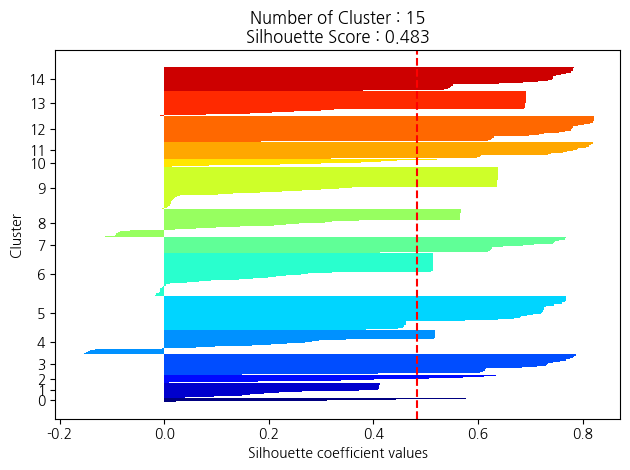

In [49]:
silhouetteviz(2, positive_topic_vectors)
silhouetteviz(3, positive_topic_vectors)
silhouetteviz(4, positive_topic_vectors)
silhouetteviz(5, positive_topic_vectors)
silhouetteviz(6, positive_topic_vectors)
silhouetteviz(7, positive_topic_vectors)
silhouetteviz(8, positive_topic_vectors)
silhouetteviz(9, positive_topic_vectors)
silhouetteviz(10, positive_topic_vectors)
silhouetteviz(11, positive_topic_vectors)
silhouetteviz(12, positive_topic_vectors)
silhouetteviz(13, positive_topic_vectors)
silhouetteviz(14, positive_topic_vectors)
silhouetteviz(15, positive_topic_vectors)

클러스터 2개일때 실루엣 계수 평균 : 0.279757545895085


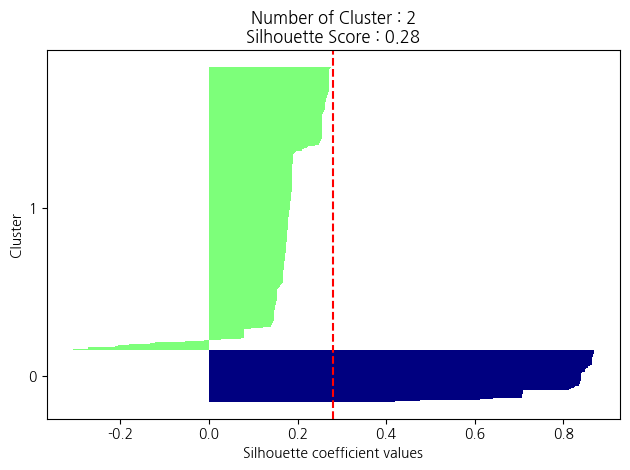

클러스터 3개일때 실루엣 계수 평균 : 0.3799459569257966


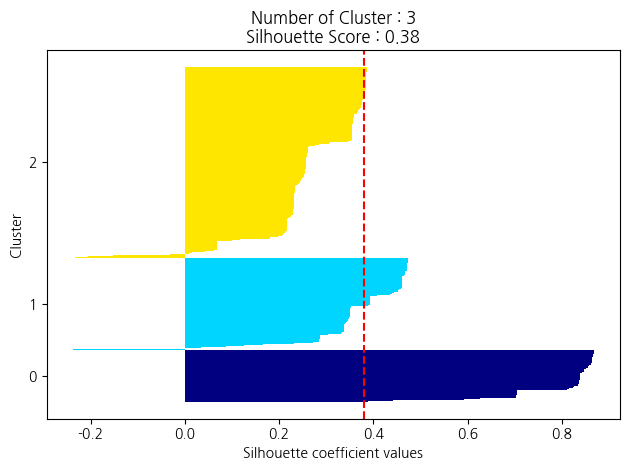

클러스터 4개일때 실루엣 계수 평균 : 0.48622437417166686


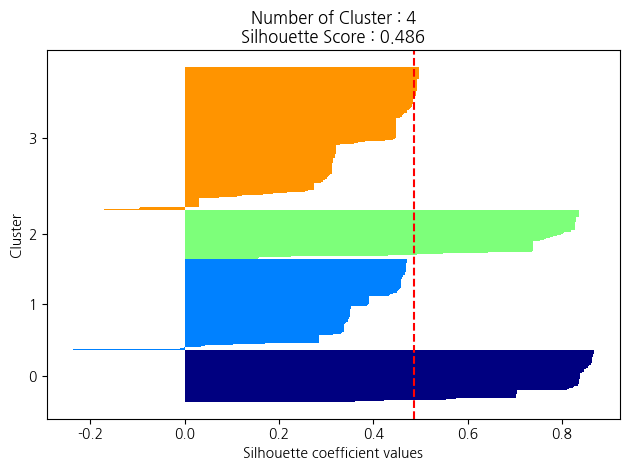

클러스터 5개일때 실루엣 계수 평균 : 0.6384161293736119


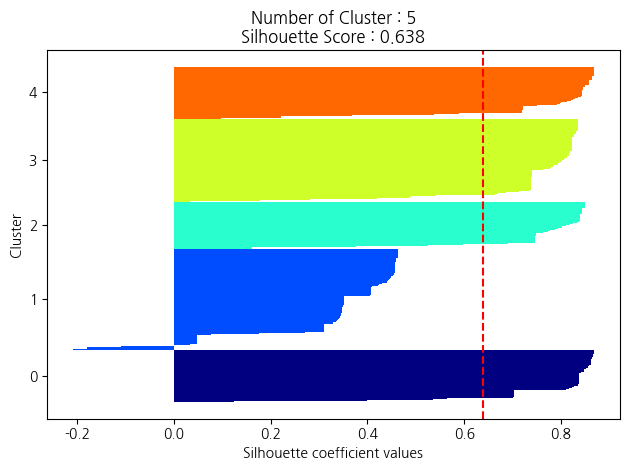

클러스터 6개일때 실루엣 계수 평균 : 0.5524204056779156


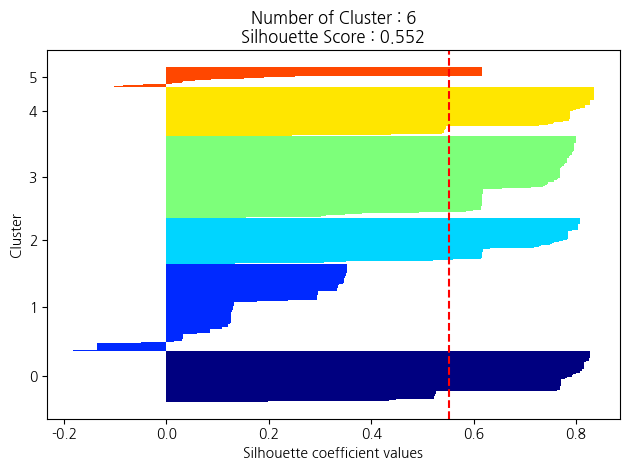

클러스터 7개일때 실루엣 계수 평균 : 0.6955061628534448


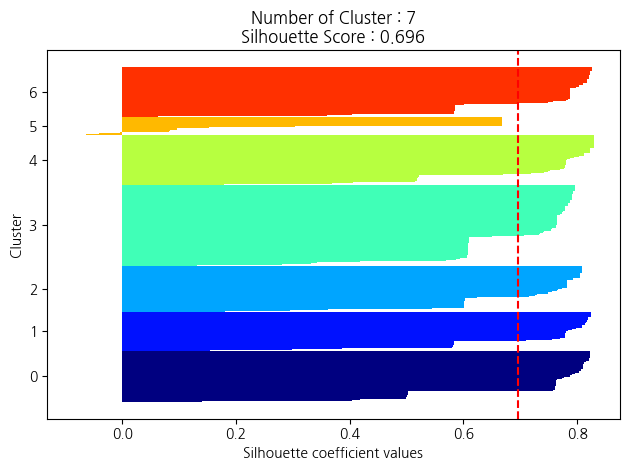

클러스터 8개일때 실루엣 계수 평균 : 0.6713872369750911


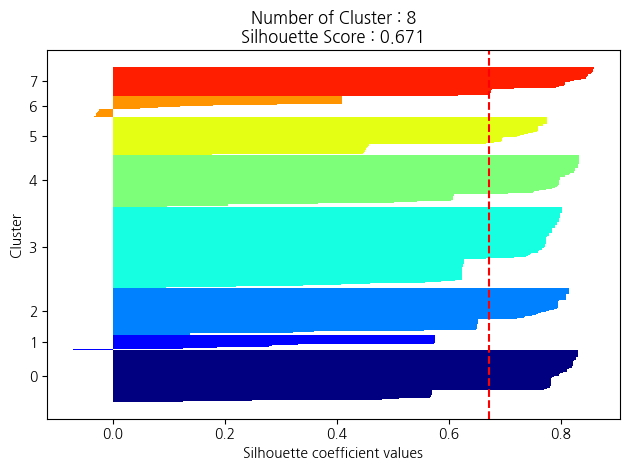

클러스터 9개일때 실루엣 계수 평균 : 0.6372139351192173


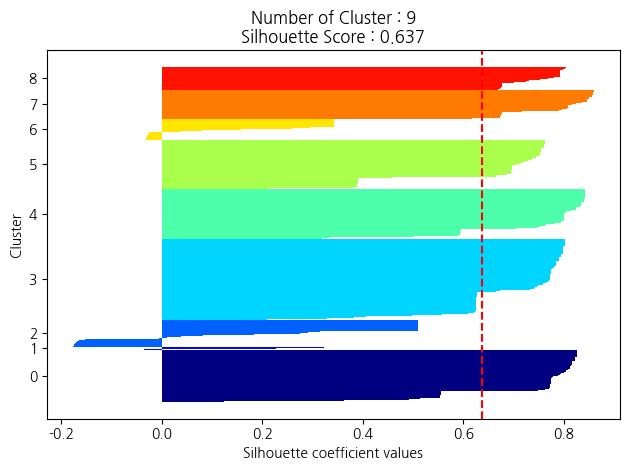

클러스터 10개일때 실루엣 계수 평균 : 0.6324518494359828


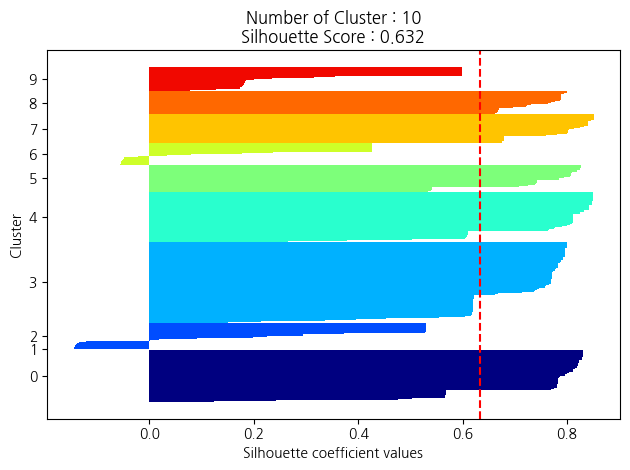

클러스터 11개일때 실루엣 계수 평균 : 0.6337309401929812


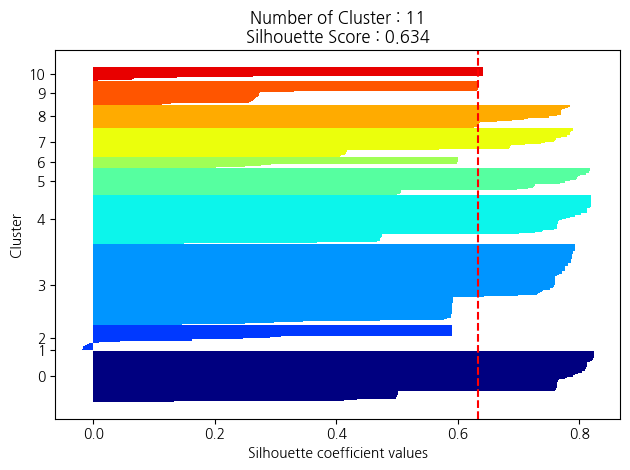

클러스터 12개일때 실루엣 계수 평균 : 0.613968435214906


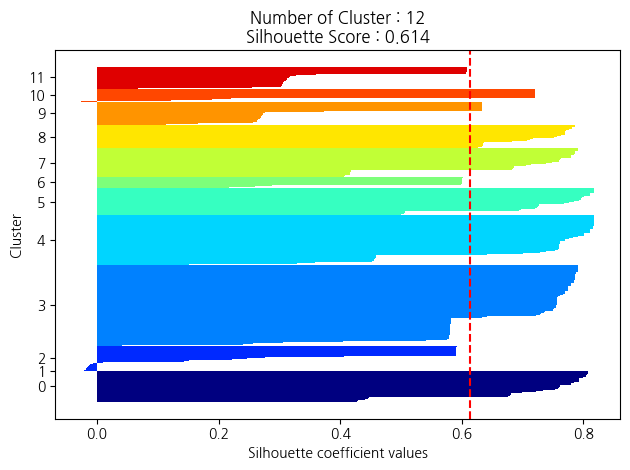

클러스터 13개일때 실루엣 계수 평균 : 0.596953846592609


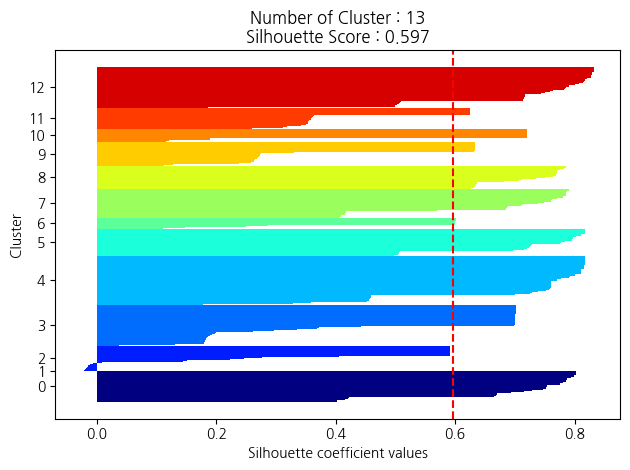

클러스터 14개일때 실루엣 계수 평균 : 0.5956390371613374


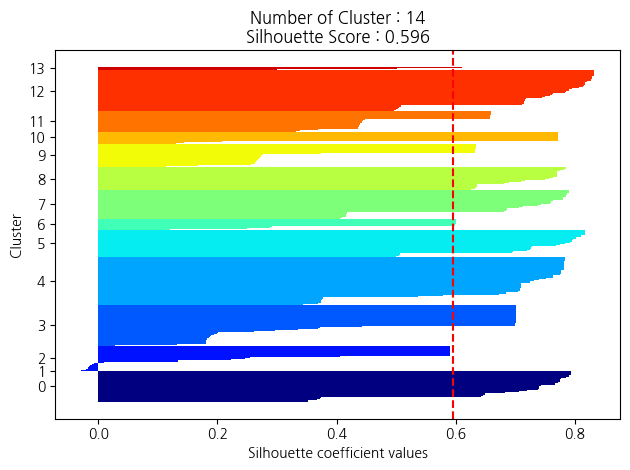

클러스터 15개일때 실루엣 계수 평균 : 0.6026723093794694


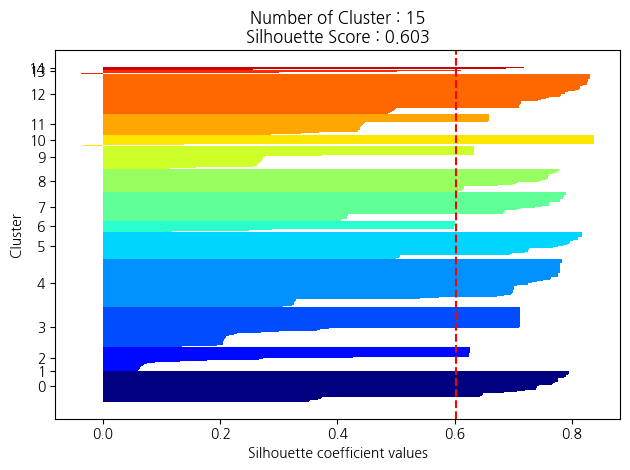

In [50]:
silhouetteviz(2, negative_topic_vectors)
silhouetteviz(3, negative_topic_vectors)
silhouetteviz(4, negative_topic_vectors)
silhouetteviz(5, negative_topic_vectors)
silhouetteviz(6, negative_topic_vectors)
silhouetteviz(7, negative_topic_vectors)
silhouetteviz(8, negative_topic_vectors)
silhouetteviz(9, negative_topic_vectors)
silhouetteviz(10, negative_topic_vectors)
silhouetteviz(11, negative_topic_vectors)
silhouetteviz(12, negative_topic_vectors)
silhouetteviz(13, negative_topic_vectors)
silhouetteviz(14, negative_topic_vectors)
silhouetteviz(15, negative_topic_vectors)

클러스터 개수 = 2, 실루엣 계수 = 0.2544
클러스터 개수 = 3, 실루엣 계수 = 0.3386
클러스터 개수 = 4, 실루엣 계수 = 0.4697
클러스터 개수 = 5, 실루엣 계수 = 0.5762
클러스터 개수 = 6, 실루엣 계수 = 0.6756
클러스터 개수 = 7, 실루엣 계수 = 0.6174
클러스터 개수 = 8, 실루엣 계수 = 0.5849
클러스터 개수 = 9, 실루엣 계수 = 0.5445
클러스터 개수 = 10, 실루엣 계수 = 0.5063
클러스터 개수 = 11, 실루엣 계수 = 0.5045
클러스터 개수 = 12, 실루엣 계수 = 0.4867
클러스터 개수 = 13, 실루엣 계수 = 0.4845
클러스터 개수 = 14, 실루엣 계수 = 0.4944
클러스터 개수 = 15, 실루엣 계수 = 0.4829


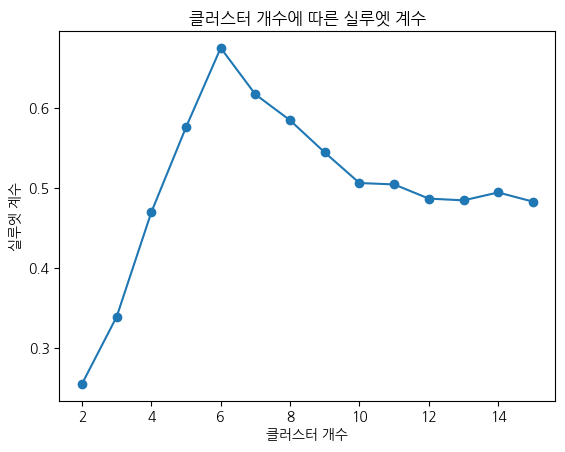

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 데이터를 준비합니다.
# 예: X는 n개의 샘플과 m개의 특징을 가진 데이터셋입니다.

# 클러스터 개수 범위 설정
range_n_clusters = range(2, 16)

# 실루엣 계수를 저장할 리스트 초기화
silhouette_avg_values = []

for n_clusters in range_n_clusters:
    # K-means 모델을 생성하고 데이터를 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(positive_topic_vectors)
    
    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(positive_topic_vectors, cluster_labels)
    silhouette_avg_values.append(silhouette_avg)
    
    print(f"클러스터 개수 = {n_clusters}, 실루엣 계수 = {silhouette_avg:.4f}")

# 실루엣 계수의 변화를 시각화
plt.plot(range_n_clusters, silhouette_avg_values, marker='o')
plt.title("클러스터 개수에 따른 실루엣 계수")
plt.xlabel("클러스터 개수")
plt.ylabel("실루엣 계수")
plt.show()

클러스터 개수 = 2, 실루엣 계수 = 0.2798
클러스터 개수 = 3, 실루엣 계수 = 0.3799
클러스터 개수 = 4, 실루엣 계수 = 0.4862
클러스터 개수 = 5, 실루엣 계수 = 0.6384
클러스터 개수 = 6, 실루엣 계수 = 0.5524
클러스터 개수 = 7, 실루엣 계수 = 0.6955
클러스터 개수 = 8, 실루엣 계수 = 0.6714
클러스터 개수 = 9, 실루엣 계수 = 0.6372
클러스터 개수 = 10, 실루엣 계수 = 0.6325
클러스터 개수 = 11, 실루엣 계수 = 0.6337
클러스터 개수 = 12, 실루엣 계수 = 0.6140
클러스터 개수 = 13, 실루엣 계수 = 0.5970
클러스터 개수 = 14, 실루엣 계수 = 0.5956
클러스터 개수 = 15, 실루엣 계수 = 0.6027


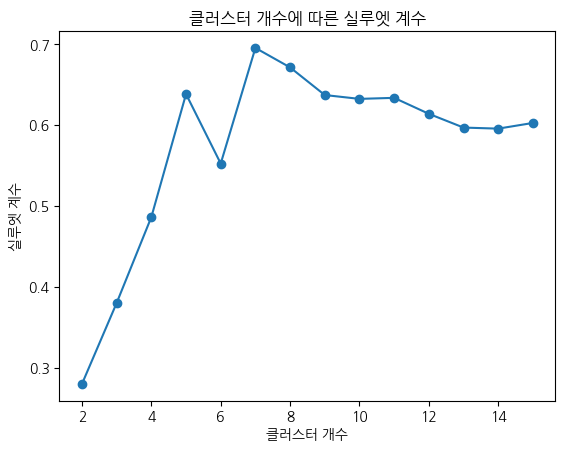

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 데이터를 준비합니다.
# 예: X는 n개의 샘플과 m개의 특징을 가진 데이터셋입니다.

# 클러스터 개수 범위 설정
range_n_clusters = range(2, 16)

# 실루엣 계수를 저장할 리스트 초기화
silhouette_avg_values = []

for n_clusters in range_n_clusters:
    # K-means 모델을 생성하고 데이터를 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(negative_topic_vectors)
    
    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(negative_topic_vectors, cluster_labels)
    silhouette_avg_values.append(silhouette_avg)
    
    print(f"클러스터 개수 = {n_clusters}, 실루엣 계수 = {silhouette_avg:.4f}")

# 실루엣 계수의 변화를 시각화
plt.plot(range_n_clusters, silhouette_avg_values, marker='o')
plt.title("클러스터 개수에 따른 실루엣 계수")
plt.xlabel("클러스터 개수")
plt.ylabel("실루엣 계수")
plt.show()

In [26]:
print(f'긍정 리뷰 전체 실루엣 계수 평균: {positive_silhouette_avg}')
print(f'부정 리뷰 전체 실루엣 계수 평균: {negative_silhouette_avg}')

긍정 리뷰 전체 실루엣 계수 평균: 0.6757288145776429
부정 리뷰 전체 실루엣 계수 평균: 0.7347688517066804


In [27]:
pip install koreanize_matplotlib

Note: you may need to restart the kernel to use updated packages.


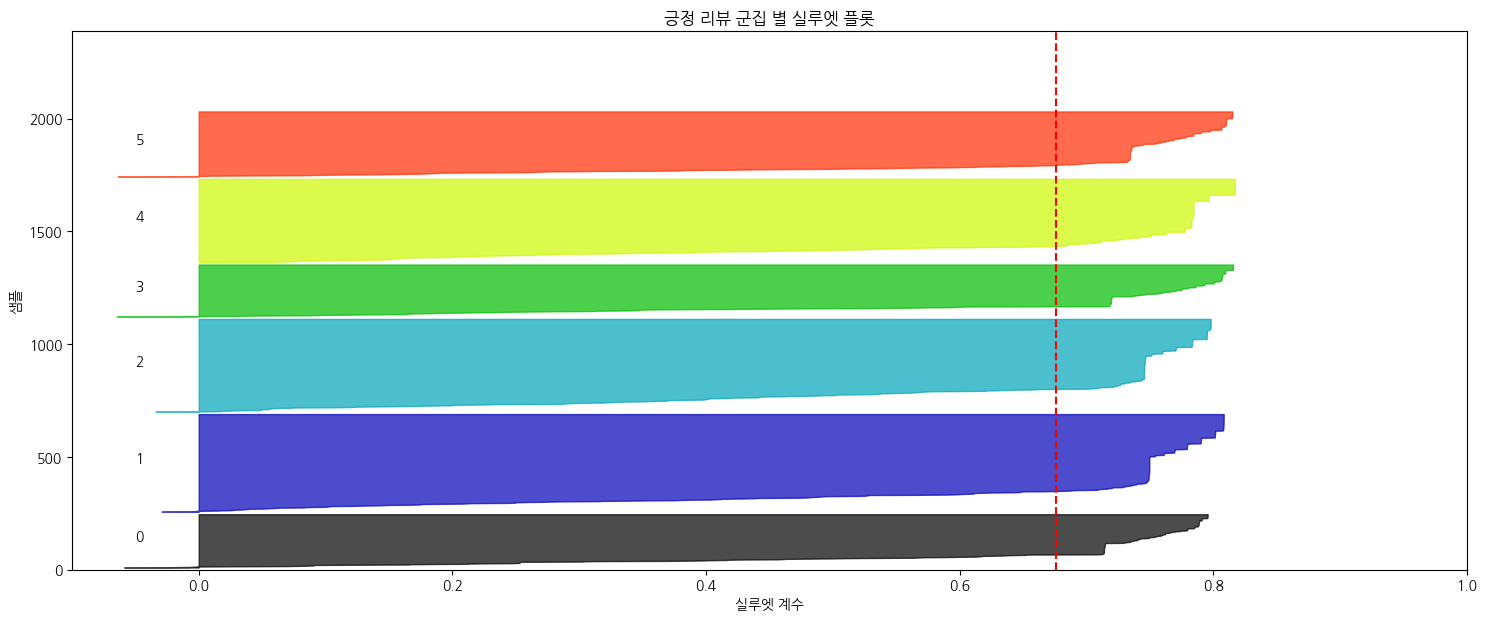

In [28]:
import koreanize_matplotlib
# 실루엣 플롯 생성 (긍정 리뷰)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(positive_reviews) + (k + 1) * 10])

y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = positive_sample_silhouette_values[positive_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("긍정 리뷰 군집 별 실루엣 플롯")
ax1.set_xlabel("실루엣 계수")
ax1.set_ylabel("샘플")

plt.axvline(x=positive_silhouette_avg, color="red", linestyle="--")
plt.show()

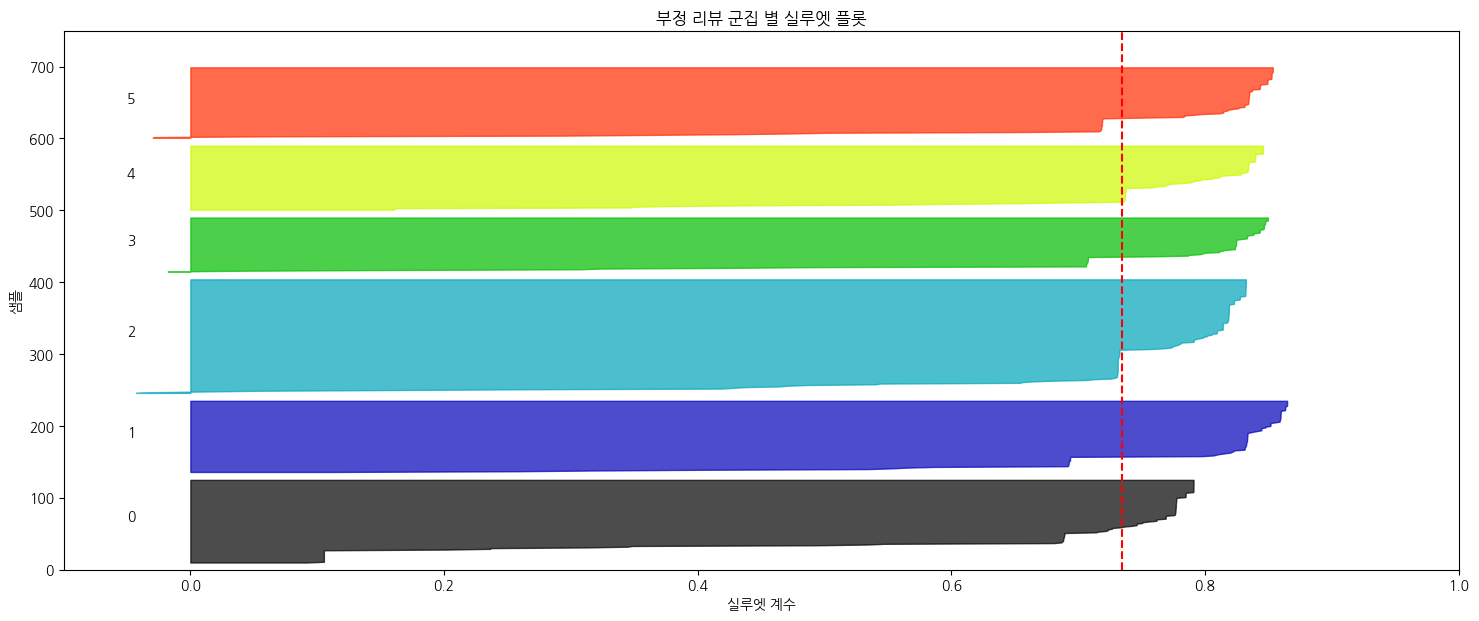

In [29]:
# 실루엣 플롯 생성 (부정 리뷰)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(negative_reviews) + (k + 1) * 10])

y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = negative_sample_silhouette_values[negative_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("부정 리뷰 군집 별 실루엣 플롯")
ax1.set_xlabel("실루엣 계수")
ax1.set_ylabel("샘플")

plt.axvline(x=negative_silhouette_avg, color="red", linestyle="--")
plt.show()

In [30]:
combined_df

NameError: name 'combined_df' is not defined

In [ ]:
import pandas as pd

# 긍정 리뷰 LDA 결과
positive_topics = positive_lda_model.show_topics(formatted=False)
positive_topics_data = []
for idx, topic in positive_topics:
    for word, weight in topic:
        positive_topics_data.append([f'Topic {idx}', word, weight])

positive_df = pd.DataFrame(positive_topics_data, columns=['Topic', 'Word', 'Weight'])

# 부정 리뷰 LDA 결과
negative_topics = negative_lda_model.show_topics(formatted=False)
negative_topics_data = []
for idx, topic in negative_topics:
    for word, weight in topic:
        negative_topics_data.append([f'Topic {idx}', word, weight])

negative_df = pd.DataFrame(negative_topics_data, columns=['Topic', 'Word', 'Weight'])

# 긍정 리뷰 단어 빈도 계산
positive_word_counts = Counter([word for tokens in positive_tokenized for word in tokens])
positive_df['Positive_Frequency'] = positive_df['Word'].apply(lambda word: positive_word_counts[word])

# 부정 리뷰 단어 빈도 계산
negative_word_counts = Counter([word for tokens in negative_tokenized for word in tokens])
negative_df['Negative_Frequency'] = negative_df['Word'].apply(lambda word: negative_word_counts[word])

# 긍정 및 부정 리뷰 데이터프레임 합치기
positive_df['Sentiment'] = 'Positive'
negative_df['Sentiment'] = 'Negative'

# 데이터프레임 병합
merged_df = pd.merge(positive_df, negative_df, on='Word', how='outer', suffixes=('_Positive', '_Negative'))

# NaN 값 0으로 대체
merged_df = merged_df.fillna(0)

# 결과 출력
print("긍정 및 부정 리뷰 LDA 결과")
print(merged_df)


긍정 및 부정 리뷰 LDA 결과
   Topic_Positive Word  Weight_Positive  Positive_Frequency  \
0         Topic 0   사용         0.043674               253.0   
1         Topic 0   사용         0.043674               253.0   
2         Topic 3   사용         0.018841               253.0   
3         Topic 3   사용         0.018841               253.0   
4         Topic 0   제품         0.043616               255.0   
..            ...  ...              ...                 ...   
67              0   용량         0.000000                 0.0   
68              0  쓰레기         0.000000                 0.0   
69              0  메모리         0.000000                 0.0   
70              0   그냥         0.000000                 0.0   
71              0   추천         0.000000                 0.0   

   Sentiment_Positive Topic_Negative  Weight_Negative  Negative_Frequency  \
0            Positive        Topic 0         0.013874               121.0   
1            Positive        Topic 3         0.063822               121

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Positive,Word,Weight_Positive,Positive_Frequency,Sentiment_Positive,Topic_Negative,Weight_Negative,Negative_Frequency,Sentiment_Negative
0,Topic 0,사용,0.043674,253.0,Positive,Topic 0,0.013874,121.0,Negative
1,Topic 0,사용,0.043674,253.0,Positive,Topic 3,0.063822,121.0,Negative
2,Topic 3,사용,0.018841,253.0,Positive,Topic 0,0.013874,121.0,Negative
3,Topic 3,사용,0.018841,253.0,Positive,Topic 3,0.063822,121.0,Negative
4,Topic 0,제품,0.043616,255.0,Positive,Topic 0,0.014726,99.0,Negative
...,...,...,...,...,...,...,...,...,...
67,0,용량,0.000000,0.0,0,Topic 2,0.010609,11.0,Negative
68,0,쓰레기,0.000000,0.0,0,Topic 2,0.008845,10.0,Negative
69,0,메모리,0.000000,0.0,0,Topic 2,0.008826,11.0,Negative
70,0,그냥,0.000000,0.0,0,Topic 3,0.010959,34.0,Negative


In [ ]:
merged_df.to_csv('merged_df.csv',encoding='utf-8-sig')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 긍정 리뷰와 부정 리뷰를 Topic으로 그룹화
positive_grouped = merged_df[merged_df['Sentiment_Positive'] == 'Positive'].groupby('Topic_Positive')
negative_grouped = merged_df[merged_df['Sentiment_Negative'] == 'Negative'].groupby('Topic_Negative')

# 각 군집별로 출력
for name, group in positive_grouped:
    print(f"긍정 리뷰 군집 {name}:")
    print(group)
    print("\n")

for name, group in negative_grouped:
    print(f"부정 리뷰 군집 {name}:")
    print(group)
    print("\n")


긍정 리뷰 군집 Topic 0:
   Topic_Positive Word  Weight_Positive  Positive_Frequency  \
0         Topic 0   사용         0.043674               253.0   
1         Topic 0   사용         0.043674               253.0   
4         Topic 0   제품         0.043616               255.0   
5         Topic 0   제품         0.043616               255.0   
6         Topic 0   제품         0.043616               255.0   
13        Topic 0   생각         0.035148               159.0   
14        Topic 0   구매         0.027000               147.0   
15        Topic 0   가격         0.017655               295.0   
18        Topic 0   도착         0.015089                87.0   
19        Topic 0   정도         0.011854                64.0   
20        Topic 0   가성         0.008859               244.0   
23        Topic 0   이상         0.008577                38.0   
24        Topic 0   충전         0.008239               112.0   

   Sentiment_Positive Topic_Negative  Weight_Negative  Negative_Frequency  \
0            Positive 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf
/usr/share/fonts/truetype/nanum/NanumGothic.ttf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
긍정 리뷰 군집 Topic 0:


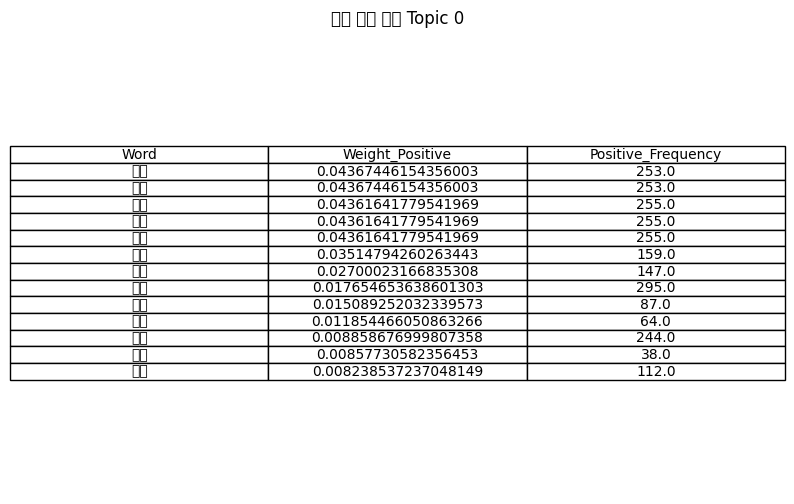

긍정 리뷰 군집 Topic 1:


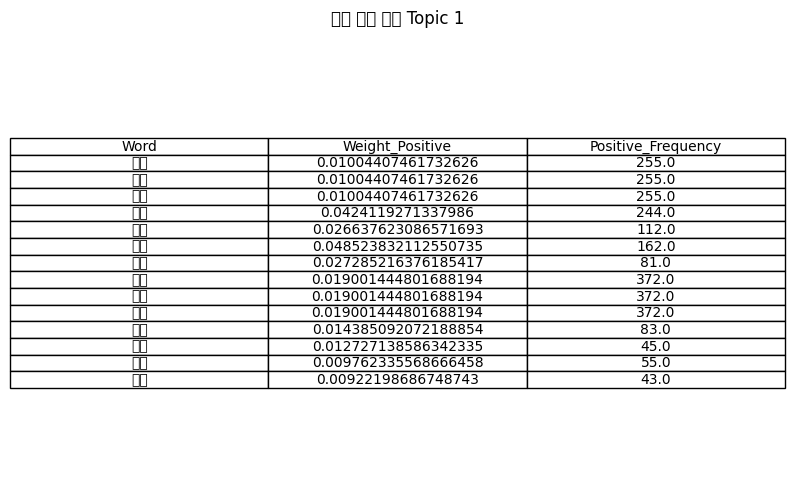

긍정 리뷰 군집 Topic 2:


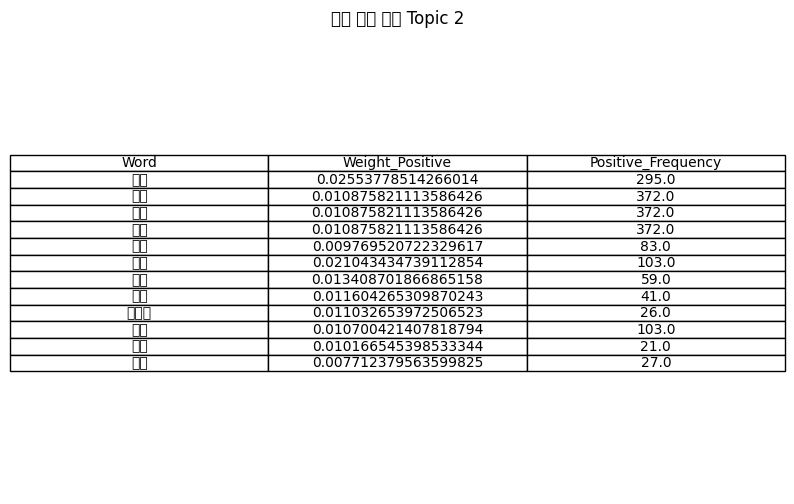

긍정 리뷰 군집 Topic 3:


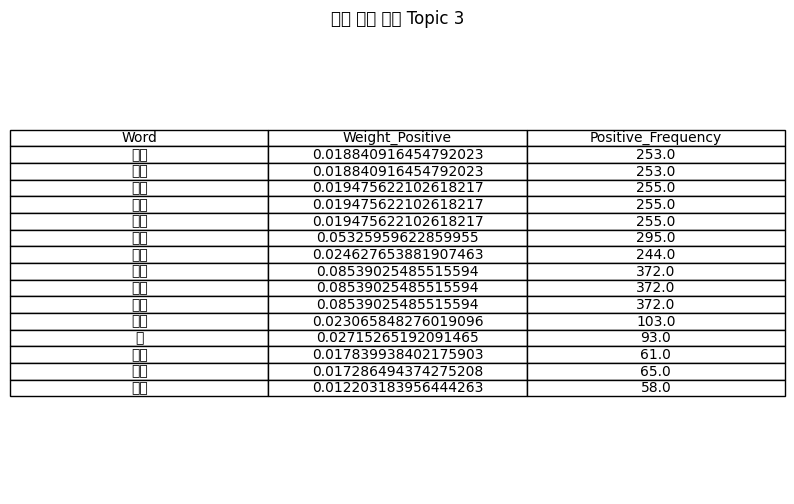

부정 리뷰 군집 Topic 0:


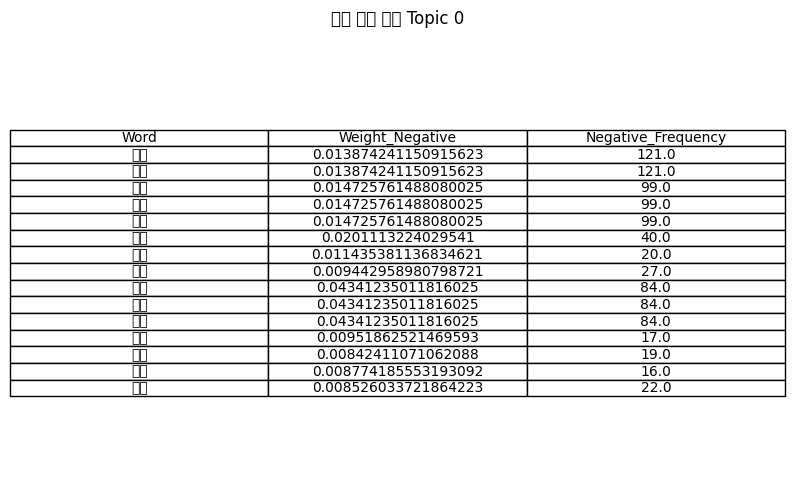

부정 리뷰 군집 Topic 1:


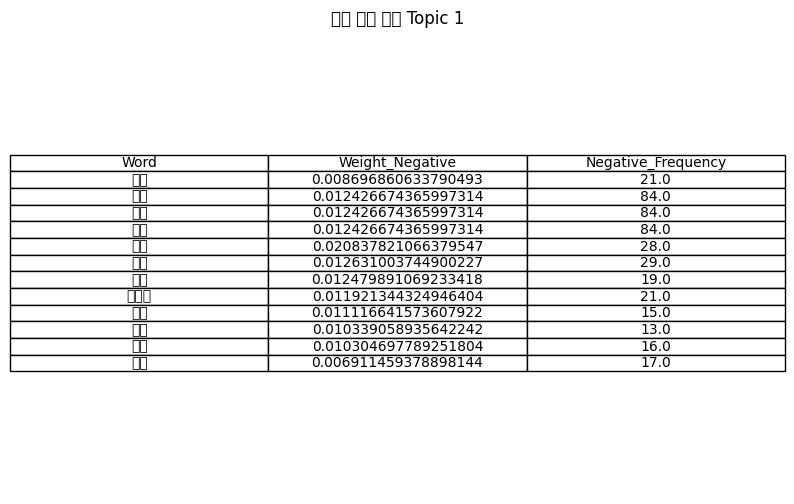

부정 리뷰 군집 Topic 2:


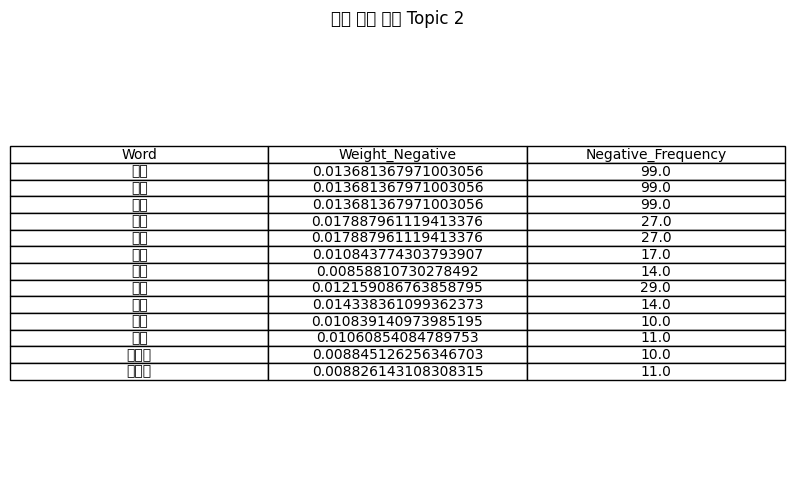

부정 리뷰 군집 Topic 3:


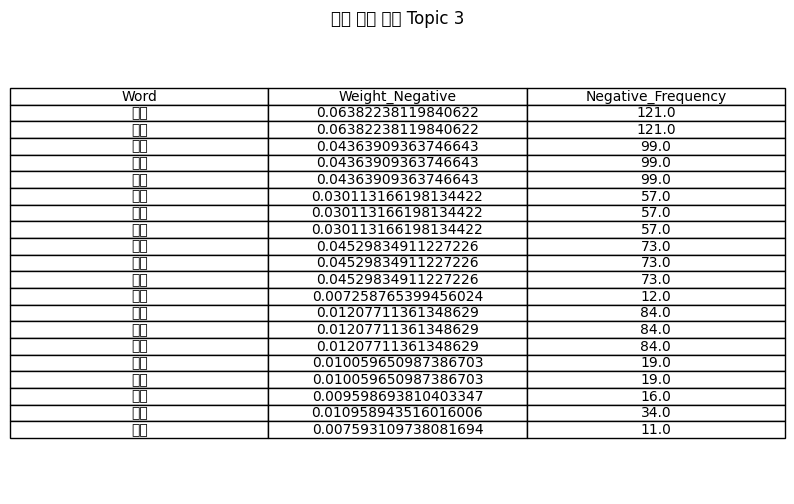

In [ ]:
# 필요한 라이브러리 임포트
import matplotlib.pyplot as plt

# 설치된 폰트 경로 확인
font_paths = fm.findSystemFonts()
for font_path in font_paths:
    if 'Nanum' in font_path:  # 나눔 폰트 경로 확인
        print(font_path)

# 나눔 폰트 경로 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'

# 표를 그리기 위한 함수 정의
def plot_cluster_data(cluster_df, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.table(cellText=cluster_df.values,
              colLabels=cluster_df.columns,
              cellLoc = 'center', rowLoc = 'center',
              loc='center')
    plt.axis('off')
    plt.show()

# 각 군집별로 데이터프레임을 만들어 시각화
for name, group in positive_grouped:
    print(f"긍정 리뷰 군집 {name}:")
    plot_cluster_data(group[['Word', 'Weight_Positive', 'Positive_Frequency']], title=f"긍정 리뷰 군집 {name}")

for name, group in negative_grouped:
    print(f"부정 리뷰 군집 {name}:")
    plot_cluster_data(group[['Word', 'Weight_Negative', 'Negative_Frequency']], title=f"부정 리뷰 군집 {name}")


In [ ]:
pip install Flask

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from gensim.corpora import Dictionary
# from gensim.models import LdaMulticore
# from gensim import corpora
# import ast


# # 데이터 샘플링
# df_sampled = df_reviews.sample(n=3000, random_state=42)

# # 'nouns' 열을 문자열에서 리스트로 변환
# df_sampled['nouns'] = df_sampled['nouns'].apply(ast.literal_eval)

# # 예외 단어 리스트 설정
# exception_words = {'굿'}

# # 한글자 단어 제거 함수 정의
# def remove_single_characters(tokens):
#     return [token for token in tokens if len(token) > 1 or token in exception_words]

# # 빈 리스트 제거 및 한글자 단어 제거
# tokenized_reviews = [remove_single_characters(tokens) for tokens in df_sampled['nouns'].tolist() if tokens]

# # 긍정과 부정 리뷰로 분리
# positive_reviews = df_sampled[df_sampled['감정'] == '긍정']
# negative_reviews = df_sampled[df_sampled['감정'] == '부정']

# # 긍정 리뷰 처리
# positive_tokenized = [remove_single_characters(tokens) for tokens in positive_reviews['nouns'].tolist() if tokens]
# positive_dictionary = corpora.Dictionary(positive_tokenized)
# positive_corpus = [positive_dictionary.doc2bow(tokens) for tokens in positive_tokenized]

# # 부정 리뷰 처리
# negative_tokenized = [remove_single_characters(tokens) for tokens in negative_reviews['nouns'].tolist() if tokens]
# negative_dictionary = corpora.Dictionary(negative_tokenized)
# negative_corpus = [negative_dictionary.doc2bow(tokens) for tokens in negative_tokenized]

# # LDA 모델 구축
# k = 4
# positive_lda_model = LdaMulticore(corpus=positive_corpus, num_topics=k, id2word=positive_dictionary, iterations=100, passes=10, workers=4)
# negative_lda_model = LdaMulticore(corpus=negative_corpus, num_topics=k, id2word=negative_dictionary, iterations=100, passes=10, workers=4)

# # 긍정 토픽 출력
# print("긍정 리뷰 토픽:")
# for idx, topic in positive_lda_model.print_topics(-1):
#     print(f'Topic: {idx} \nWords: {topic}\n')

# # 부정 토픽 출력
# print("부정 리뷰 토픽:")
# for idx, topic in negative_lda_model.print_topics(-1):
#     print(f'Topic: {idx} \nWords: {topic}\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


긍정 리뷰 토픽:
Topic: 0 
Words: 0.057*"가격" + 0.047*"아주" + 0.039*"사용" + 0.033*"대비" + 0.023*"가성" + 0.021*"최고" + 0.016*"만족" + 0.011*"성능" + 0.010*"정도" + 0.008*"도착"

Topic: 1 
Words: 0.028*"충전" + 0.027*"작동" + 0.018*"추천" + 0.017*"매우" + 0.012*"구매" + 0.012*"마음" + 0.011*"배송" + 0.011*"조금" + 0.010*"소리" + 0.009*"게임"

Topic: 2 
Words: 0.089*"배송" + 0.063*"제품" + 0.026*"가격" + 0.024*"사용" + 0.020*"구매" + 0.017*"생각" + 0.017*"가성" + 0.012*"품질" + 0.012*"도착" + 0.012*"상품"

Topic: 3 
Words: 0.046*"가성" + 0.037*"굿" + 0.027*"생각" + 0.023*"사용" + 0.019*"가격" + 0.014*"구매" + 0.011*"사이즈" + 0.010*"느낌" + 0.008*"문제" + 0.008*"크기"

부정 리뷰 토픽:
Topic: 0 
Words: 0.072*"사용" + 0.052*"가성" + 0.043*"제품" + 0.030*"배송" + 0.024*"가격" + 0.012*"생각" + 0.010*"작동" + 0.009*"기능" + 0.009*"정도" + 0.008*"하나"

Topic: 1 
Words: 0.016*"그냥" + 0.016*"구매" + 0.012*"가격" + 0.010*"확인" + 0.009*"게임" + 0.009*"설치" + 0.008*"연결" + 0.007*"사지" + 0.007*"화면" + 0.007*"밝기"

Topic: 2 
Words: 0.017*"한국어" + 0.017*"충전" + 0.016*"환불" + 0.014*"사용" + 0.014*"한글" + 0.013*"배송" + 0.012*"지

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis
# import matplotlib.pyplot as plt

# # pyLDAvis 시각화 생성
# positive_vis2 = gensimvis.prepare(positive_lda_model, positive_corpus, positive_dictionary)
# negative_vis2 = gensimvis.prepare(negative_lda_model, negative_corpus, negative_dictionary)

# # 코랩에서 시각화 표시
# pyLDAvis.enable_notebook()

# # 긍정 리뷰 시각화
# positive_vis2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.089330 -0.103690       1        1  32.862479
1     -0.089215  0.081102       2        1  25.266009
0      0.115040 -0.067170       3        1  21.935988
3      0.063505  0.089759       4        1  19.935524, topic_info=    Term        Freq       Total Category  logprob  loglift
4     배송  307.000000  307.000000  Default  30.0000  30.0000
1     제품  211.000000  211.000000  Default  29.0000  29.0000
101    굿   74.000000   74.000000  Default  28.0000  28.0000
5     아주  133.000000  133.000000  Default  27.0000  27.0000
3     대비   84.000000   84.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
7     음질    8.383861   40.120248   Topic4  -5.4119   0.0471
58    도착    8.519405   72.139711   Topic4  -5.3959  -0.5236
33    소리    7.352444   46.038961   Topic4  -5.5432  -0.2218
9     충전    7.496481   93.629541   Topic4  -5.5238  -0.9122
119   색상    6.380667   22.950159   Topic4  -5.6850   0.3326

[285 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.327335   가격
2         2  0.037291   가격
2         3  0.488930   가격
2         4  0.149165   가격
56        1  0.257130   가성
...     ...       ...  ...
60        2  0.093884   후기
60        3  0.234710   후기
60        4  0.093884   후기
326       4  0.939307   후회
725       1  0.729833   흡수

[444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [ ]:
# negative_vis2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.151569 -0.031714       1        1  27.987886
3      0.001088  0.096859       2        1  26.723868
2      0.075304 -0.117111       3        1  25.474631
1      0.075177  0.051966       4        1  19.813616, topic_info=    Term       Freq      Total Category  logprob  loglift
20    사용  90.000000  90.000000  Default  30.0000  30.0000
100   가성  55.000000  55.000000  Default  29.0000  29.0000
13    제품  73.000000  73.000000  Default  28.0000  28.0000
148  한국어  16.000000  16.000000  Default  27.0000  27.0000
166   가격  42.000000  42.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
191   인식   2.843032  10.204084   Topic4  -5.5096   0.3409
18    별로   2.959878  14.544039   Topic4  -5.4693   0.0268
99    환불   3.064859  21.288241   Topic4  -5.4345  -0.3194
54    구입   2.936983  14.475385   Topic4  -5.4771   0.0237
14    배송   3.084863  62.593791   Topic4  -5.4280  -1.3914

[262 rows x 6 columns], token_table=      Topic      Freq Term
term                      
166       1  0.565392   가격
166       2  0.235580   가격
166       4  0.188464   가격
100       1  0.926909   가성
100       2  0.036349   가성
...     ...       ...  ...
178       4  0.905214   확인
99        1  0.140923   환불
99        3  0.704614   환불
99        4  0.140923   환불
360       3  0.814369  휴대폰

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [ ]:
# from gensim.corpora import Dictionary
# from gensim.models import LdaMulticore
# from gensim import corpora
# import ast


# # 데이터 샘플링
# df_sampled = df_reviews.sample(n=3000, random_state=42)

# # 'nouns' 열을 문자열에서 리스트로 변환
# df_sampled['nouns'] = df_sampled['nouns'].apply(ast.literal_eval)

# # 예외 단어 리스트 설정
# exception_words = {'굿'}

# # 한글자 단어 제거 함수 정의
# def remove_single_characters(tokens):
#     return [token for token in tokens if len(token) > 1 or token in exception_words]

# # 빈 리스트 제거 및 한글자 단어 제거
# tokenized_reviews = [remove_single_characters(tokens) for tokens in df_sampled['nouns'].tolist() if tokens]

# # 긍정과 부정 리뷰로 분리
# positive_reviews = df_sampled[df_sampled['감정'] == '긍정']
# negative_reviews = df_sampled[df_sampled['감정'] == '부정']

# # 긍정 리뷰 처리
# positive_tokenized = [remove_single_characters(tokens) for tokens in positive_reviews['nouns'].tolist() if tokens]
# positive_dictionary = corpora.Dictionary(positive_tokenized)
# positive_corpus = [positive_dictionary.doc2bow(tokens) for tokens in positive_tokenized]

# # 부정 리뷰 처리
# negative_tokenized = [remove_single_characters(tokens) for tokens in negative_reviews['nouns'].tolist() if tokens]
# negative_dictionary = corpora.Dictionary(negative_tokenized)
# negative_corpus = [negative_dictionary.doc2bow(tokens) for tokens in negative_tokenized]

# # LDA 모델 구축
# k = 4
# positive_lda_model = LdaMulticore(corpus=positive_corpus, num_topics=k, id2word=positive_dictionary, iterations=100, passes=10, workers=4)
# negative_lda_model = LdaMulticore(corpus=negative_corpus, num_topics=k, id2word=negative_dictionary, iterations=100, passes=10, workers=4)

# # 긍정 토픽 출력
# print("긍정 리뷰 토픽:")
# for idx, topic in positive_lda_model.print_topics(-1):
#     print(f'Topic: {idx} \nWords: {topic}\n')

# # 부정 토픽 출력
# print("부정 리뷰 토픽:")
# for idx, topic in negative_lda_model.print_topics(-1):
#     print(f'Topic: {idx} \nWords: {topic}\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


긍정 리뷰 토픽:
Topic: 0 
Words: 0.050*"가성" + 0.023*"가격" + 0.022*"작동" + 0.018*"구매" + 0.015*"만족" + 0.013*"굿" + 0.012*"마음" + 0.012*"배송" + 0.012*"소리" + 0.011*"추천"

Topic: 1 
Words: 0.079*"배송" + 0.042*"아주" + 0.027*"생각" + 0.025*"사용" + 0.023*"가성" + 0.021*"최고" + 0.017*"도착" + 0.014*"가격" + 0.012*"물건" + 0.012*"구매"

Topic: 2 
Words: 0.044*"가격" + 0.026*"사용" + 0.023*"대비" + 0.020*"충전" + 0.018*"굿" + 0.017*"제품" + 0.016*"추천" + 0.014*"게임" + 0.010*"한국" + 0.010*"배송"

Topic: 3 
Words: 0.064*"제품" + 0.035*"사용" + 0.027*"매우" + 0.027*"배송" + 0.023*"가격" + 0.013*"구매" + 0.013*"생각" + 0.012*"가성" + 0.011*"작동" + 0.011*"품질"

부정 리뷰 토픽:
Topic: 0 
Words: 0.059*"사용" + 0.055*"제품" + 0.050*"가성" + 0.014*"배송" + 0.012*"충전" + 0.011*"환불" + 0.009*"하나" + 0.008*"사지" + 0.007*"색상" + 0.007*"다른"

Topic: 1 
Words: 0.038*"가격" + 0.034*"배송" + 0.015*"그냥" + 0.013*"도착" + 0.012*"대비" + 0.011*"제품" + 0.010*"반품" + 0.010*"구매" + 0.010*"환불" + 0.009*"한글"

Topic: 2 
Words: 0.017*"사용" + 0.017*"구매" + 0.013*"상품" + 0.012*"한글" + 0.010*"설명" + 0.009*"지원" + 0.008*"구입" 

In [ ]:
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis
# import matplotlib.pyplot as plt

# # pyLDAvis 시각화 생성
# positive_vis3 = gensimvis.prepare(positive_lda_model, positive_corpus, positive_dictionary)
# negative_vis3 = gensimvis.prepare(negative_lda_model, negative_corpus, negative_dictionary)

# # 코랩에서 시각화 표시
# pyLDAvis.enable_notebook()

# # 긍정 리뷰 시각화
# positive_vis3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.078332  0.100470       1        1  25.932088
1      0.106490 -0.029942       2        1  25.616087
0     -0.084231 -0.107005       3        1  24.797428
3      0.056073  0.036477       4        1  23.654397, topic_info=   Term        Freq       Total Category  logprob  loglift
1    제품  208.000000  208.000000  Default  30.0000  30.0000
4    배송  304.000000  304.000000  Default  29.0000  29.0000
56   가성  199.000000  199.000000  Default  28.0000  28.0000
54   매우   66.000000   66.000000  Default  27.0000  27.0000
5    아주  133.000000  133.000000  Default  26.0000  26.0000
..  ...         ...         ...      ...      ...      ...
31   정도   12.009215   53.469662   Topic4  -5.2236  -0.0518
52   정말   11.106818   44.788745   Topic4  -5.3017   0.0472
9    충전    9.028178   93.229379   Topic4  -5.5089  -0.8931
5    아주    9.211948  133.277036   Topic4  -5.4888  -1.2303
40   성능    8.479301   54.001051   Topic4  -5.5717  -0.4098

[283 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.439768   가격
2         2  0.135630   가격
2         3  0.217829   가격
2         4  0.205499   가격
56        1  0.010043   가성
...     ...       ...  ...
60        1  0.741941   후기
60        2  0.139114   후기
60        3  0.046371   후기
60        4  0.092743   후기
725       2  0.734137   흡수

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [ ]:
# negative_vis3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118506  0.081818       1        1  29.837636
1     -0.122624  0.064572       2        1  28.952289
2     -0.014153 -0.027661       3        1  21.871286
3      0.018271 -0.118728       4        1  19.338788, topic_info=    Term       Freq      Total Category  logprob  loglift
100   가성  56.000000  56.000000  Default  30.0000  30.0000
166   가격  42.000000  42.000000  Default  29.0000  29.0000
13    제품  75.000000  75.000000  Default  28.0000  28.0000
20    사용  90.000000  90.000000  Default  27.0000  27.0000
235   속도  10.000000  10.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
54    구입   3.185673  14.419820   Topic4  -5.3716   0.1331
47    시간   2.922271  10.102691   Topic4  -5.4579   0.4026
194   주문   2.911286  12.347840   Topic4  -5.4616   0.1982
18    별로   2.944509  14.597438   Topic4  -5.4503   0.0422
166   가격   2.936041  42.686794   Topic4  -5.4532  -1.0338

[259 rows x 6 columns], token_table=      Topic      Freq Term
term                      
166       2  0.913632   가격
166       4  0.070279   가격
534       2  0.814101   가능
100       1  0.926471   가성
100       2  0.053450   가성
...     ...       ...  ...
720       1  0.664999   회사
991       1  0.460004   후기
991       2  0.153335   후기
991       4  0.460004   후기
163       3  0.927522   흰색

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])